In [1]:
# Import all the functions from DOLFIN (computational backend of the FEniCS project)
from fenics import *
from dolfin import * 
import numpy as np
import matplotlib.pyplot as plt

## Checking code

In [2]:
import numpy as np
import argparse
import os
from solver_funcs import F_operator, mu_from_params
import matplotlib.pyplot as plt
from utils import noise_addition_image

from posterior_funcs import Posterior, MuVector, Prior

In [3]:
def get_y(mu_vect):
    mu, y = F_operator(mu_vect.vector)
    mask = mu != 100
    mask = mask.astype(int)
    mask = np.repeat(mask, 2, axis=3)
    y = np.multiply(y, mask)
    return mu, y


mu_vect = MuVector()
_ = mu_vect.sample_vector()
mu_vect.vector = np.load("results_100percentnoise_1/mu_vect.npy")

mu, y = get_y(mu_vect)

/Users/javiermurgoitioesandi/Desktop/WIP/InverseProblems/InverseProblems_MCMC/ONHFenics_SamplingPosterior/mu_funcs_given.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  (self.LC_y_3 - self.LC_y_2) / (self.LC_x_3 - self.LC_x_2),
/Users/javiermurgoitioesandi/Desktop/WIP/InverseProblems/InverseProblems_MCMC/ONHFenics_SamplingPosterior/mu_funcs_given.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  (self.LC_y_4 - self.LC_y_1) / (self.LC_x_4 - self.LC_x_1),
/Users/javiermurgoitioesandi/Desktop/WIP/InverseProblems/InverseProblems_MCMC/ONHFenics_SamplingPosterior/mu_funcs_given.py:220: RuntimeWarning: divide by zero encountered in scalar divide
  (self.SCTL_y_3 - self.SCTL_y_2) / (self.SCTL_x_3 - self.SCTL_x_2),
/Users/javiermurgoitioesandi/Desktop/WIP/InverseProblems/InverseProblems_MCMC/ONHFenics_SamplingPosterior/mu_funcs_given.py:486: RuntimeWarning: divide by zero encountered in scalar divide
  (self.ULC_y_3 - self.ULC_y_2) / (self.ULC_x_3 - sel

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.338e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.734e-17 (tol = 1.000e-10) r (rel) = 5.089e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


In [8]:
mu_vect.get_vector().size

33

## Main code

In [44]:
# 20 is number of intervals Omega is divided into
mesh = UnitSquareMesh(64, 64)
# here interval is a FEniCS builtin representing a single interval
elem = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
W = FunctionSpace(mesh, elem)

kappa = Constant(0.25)  # physical material property
S = Constant(0.0)  # source term

dt = Constant(0.01)  # time step
nb_t = 10  # number of time step - loop

v = TestFunction(W)  # the test function
# the TrialFunction is basically a symbol representing the unknown
u = TrialFunction(W)
u_old = Function(W)  # Solution at previous time step. Initialized to zero.


# value_left = Constant(0.0)
# value_right = Constant(2.0)
# # Imposing Dirichlet BC to the left boundary node
# bc_l = DirichletBC(W, value_left, "on_boundary && near(x[0], 0)")
# # Imposing Dirichlet BC to the right boundary node
# bc_r = DirichletBC(W, value_right, "on_boundary && near(x[0], 1)")
# bcs = [bc_l, bc_r]   # list of boundary conditions to apply to the problem



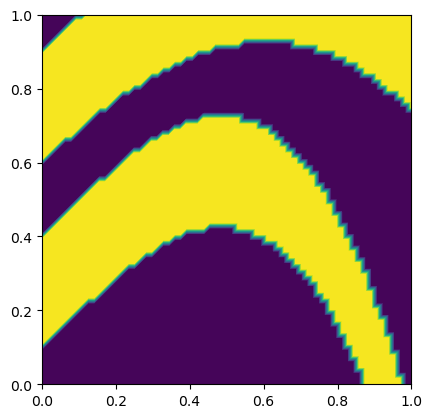

In [54]:
kappa_over_mu = Constant(1.0)  # physical material property

a1 = np.random.uniform(-1,1)
b1 = np.random.normal(0,0.5)
#c1 = np.random.uniform(-1,1)
c1 = np.random.normal(0,1)

a2 = a1
b2 = np.random.normal(0,0.5)
# c2 = np.random.uniform(-1,1)
c2 = np.random.normal(0,1)

P = FunctionSpace(mesh, "Lagrange", 1)
class Kappa_dom(UserExpression):
    def __init__(self, a1, b1, c1, a2, b2, c2, **kwargs):
        super().__init__()
        self.a1 = a1
        self.b1 = b1
        self.c1 = c1
        self.a2 = a2
        self.b2 = b2
        self.c2 = c2

    def eval(self, value, x):
        y1 = self.a1 * x[0] + self.b1 * x[0]**2 + self.c1 * x[0]**3 + 0.1
        y2 = self.a1 * x[0] + self.b1 * x[0]**2 + self.c1 * x[0]**3 + 0.4
        y3 = self.a2 * x[0] + self.b2 * x[0]**2 + self.c2 * x[0]**3 + 0.6
        y4 = self.a2 * x[0] + self.b2 * x[0]**2 + self.c2 * x[0]**3 + 0.9

        if (x[1] > y1 and x[1] < y2) or (x[1] > y3 and x[1] < y4):
            value[0] = 21.2
        else:
            value[0] = 1.0

    def value_shape(self):
        return ()

kappa_init = Kappa_dom(a1, b1, c1, a2, b2, c2, degree=0)
u_old = interpolate(kappa_init, P)

plot(u_old)

0.0


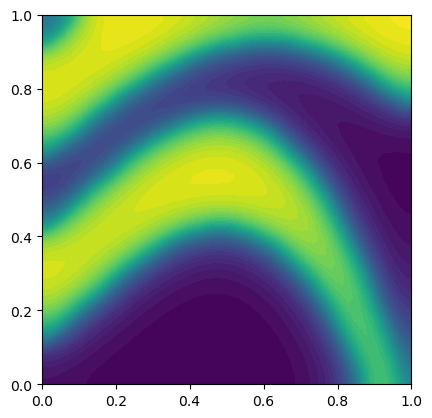

0.05


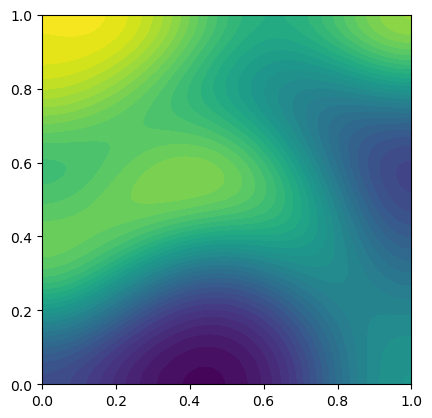

In [55]:
a = (u * v) / dt * dx + kappa * dot(grad(u), grad(v)) * \
    dx  # left hand side of our equation
L = (u_old * v) / dt * dx + S * v * dx  # right hand side of our equation

uh = Function(W)  # place to store the solution

A = assemble(a)
# for bc in bcs:
#     bc.apply(A)

solver = LUSolver(A)
i = 0
for t in range(nb_t):
    b = assemble(L)  # Reassemble L on every time step
    # for bc in bcs:  # RE-apply bc to b
    #     bc.apply(b)
    solver.solve(uh.vector(), b)  # Solve on given time step
    assign(u_old, uh)

    if i == 0:
        print(i*dt(0))
        plot(uh)
        plt.show()
    elif i == 5:
        print(i*dt(0))
        plot(uh)
        plt.show()
    # fig = plt.figure()
    # im = plot(uh)
    # fig.colorbar(im)
    # plt.show()
    i += 1

In [ ]:
# print the value of a Costant from fenics :)
# print(kappa(0,0))
